# FIM (Freqent Itemset Mining) discovery

In [2]:
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Create toy example to play with

In [3]:
transactions = [
    {'b'},
    {'a', 'b'},
    {'a', 'b'},
    {'a', 'b', 'c'},
    {'b', 'c', 'd'},
    {'d', 'a'},
    {'a', 'b', 'c'},
    {'c', 'd', 'e'},
    {'b', 'c', 'd', 'e'},
    {'b', 'c', 'd', 'e'},
]

transactions = [set(t) for t in transactions]
transactions

[{'b'},
 {'a', 'b'},
 {'a', 'b'},
 {'a', 'b', 'c'},
 {'b', 'c', 'd'},
 {'a', 'd'},
 {'a', 'b', 'c'},
 {'c', 'd', 'e'},
 {'b', 'c', 'd', 'e'},
 {'b', 'c', 'd', 'e'}]

# Candidates generation

<div>
<img src="img/candidates_generation.png" width="500"/>
</div>

In [4]:
def generate_candidates(Fk):
    """
    Generates candidates for FPM (Frequent Pattern Mining)
    based on the previous level.

    Input: 
    Fk is a list of frequent candidates at the level k.
    
    Output: 
    Candidates for the next level k+1.
    """
    E = []

    # traverse all pairs of frequent item sets 
    # that share the same maximal prefix 
    # (they are in lexicographic order) 
    # and differ only in one last item

    for f1 in Fk:
        for f2 in Fk:

            # use lexicographic order
            # so consider 2nd element in a pair
            # that is located on the right
            if f1 < f2:

                # check if f1 and f2 share the same maximal prefix 
                # and differ only in the last attribute
                if f1[:-1] == f2[:-1]:

                    # make new candidate with k+1 attributes 
                    # using a union of f1 and f2
                    f = f1 + f2[-1]

                    # if all subsets with k items are frequent
                    # then we add new candidate
                    # (otherwisse it can not be frequent)
                    if all(''.join(sorted(set(f) - set(i))) in Fk for i in f):
                        E.append(''.join(f))             
                               
    return E

In [5]:
generate_candidates(['a', 'b', 'c', 'd', 'e'])

['ab', 'ac', 'ad', 'ae', 'bc', 'bd', 'be', 'cd', 'ce', 'de']

In [6]:
generate_candidates(['ab', 'ac', 'ad', 'ae', 'bc', 'bd', 'be', 'cd', 'ce', 'de'])

['abc', 'abd', 'abe', 'acd', 'ace', 'ade', 'bcd', 'bce', 'bde', 'cde']

# Prune

<div>
<img src="img/pruning.png" width="500"/>
</div>

In [7]:
def prune(E, T, smin):
    """
    E is generated candidates
    T is a transaction database: T = (t1, t2, ..., tn)
    smin is a minimum support
    """

    # calculate how many times the candidate
    # is a subset of transactions
    cntr = {}
    for e in E:
        cntr[e] = 0
        for t in T:
            if set(e).issubset(t):
                cntr[e] += 1

    # prune
    F = []
    for e in E:
        if cntr[e] >= smin:
            F.append(e)
    
    return F

In [8]:
prune(
    E=['ab', 'ac', 'ad', 'ae', 'bc', 'bd', 'be', 'cd', 'ce', 'de'],
    T=transactions,
    smin=2
)

['ab', 'ac', 'bc', 'bd', 'be', 'cd', 'ce', 'de']

# Apriori

<div>
<img src="img/apriori_fim.png" width="500"/>
</div>

In [9]:
def get_catalog(T):
    """
    Gets distinct items from transaction database.
    """
    catalog = sorted(set().union(*T))
    return catalog

catalog = get_catalog(T=transactions)
catalog

['a', 'b', 'c', 'd', 'e']

In [10]:
def apriori(B, T, smin):
    """
    B is item base: B = {i1, i2, ..., im}
    T is a transaction database: T = {t1, t2, ..., tn}
    smin is a minimum support
    """
    FIM = []

    k = 1

    E = B
    F = prune(E, T, smin)
    FIM.extend(F)

    # FOR VUSIALISATION
    lattice_data = defaultdict(dict)
    lattice_data[k]['all'] = E
    lattice_data[k]['F'] = F

    while len(F) > 0:

        k += 1

        all_next = generate_candidates(E)
        E_next = generate_candidates(F)
        F_next = prune(E_next, T, smin)
        FIM.extend(F_next)

        # FOR VUSIALISATION
        lattice_data[k]['all'] = all_next
        lattice_data[k]['F'] = F_next # frequent

        E = all_next
        F = F_next

    return lattice_data, FIM

In [11]:
lattice_data , FIM = apriori(
    B=catalog,
    T=transactions,
    smin=2
)

FIM

['a',
 'b',
 'c',
 'd',
 'e',
 'ab',
 'ac',
 'bc',
 'bd',
 'be',
 'cd',
 'ce',
 'de',
 'abc',
 'bcd',
 'bce',
 'bde',
 'cde',
 'bcde']

# Visualisation

In [14]:
def draw_lattice(lattice_data):

    G = nx.DiGraph()

    pos = {}
    level_spacing = 2.0  # vertical spacing between levels
    node_spacing = 1.0   # horizontal spacing between nodes within a level

    for level, data in lattice_data.items():
        nodes = data['all']
        num_nodes = len(nodes)
        level_pos = {node: ((i - num_nodes / 2) * node_spacing, (level - 1) * level_spacing) for i, node in enumerate(nodes)}
        pos.update(level_pos)
        G.add_nodes_from(nodes)

        if level > 1:
            # connect nodes to nodes in the previous level
            prev_nodes = lattice_data[level - 1]['all']
            for node in nodes:
                for prev_node in prev_nodes:
                    if set(node).issuperset(prev_node):
                        G.add_edge(prev_node, node)

    node_colors = ['lightgreen' if node in lattice_data[level]['F'] else 'lightgrey' 
                for level in lattice_data for node in lattice_data[level]['all']]

    fig, ax = plt.subplots(figsize=(8, 6))

    nx.draw(
        G=G, 
        pos=pos, 
        with_labels=True, 
        font_weight='bold', 
        font_family='Comic Sans MS',
        node_size=700,
        node_color=node_colors, 
        edgecolors=node_colors, # color of node boarder
        linewidths=0.5, # thickness of node boarder
        alpha=0.8, # transparency
        font_size=9, 
        arrowsize=10,
        width=0.5, # edge width
        edge_color='grey', # edge color
    )

    legend_labels = {
        'candidates': 'lightgrey', 
        'FIM': 'lightgreen',
    }
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'{label}', markerfacecolor=color, markersize=10) 
                    for label, color in legend_labels.items()]

    plt.legend(
        handles=legend_handles, 
        loc='lower right', 
        bbox_to_anchor=(1.05, 0.05), 
        borderaxespad=0.0,
        fontsize=8,
    )
    plt.title(
        label='Lattice for FIM (Freqent Itemset Mining) discovery', 
        fontweight='bold', 
        fontfamily='Comic Sans MS'
    )
    plt.show()

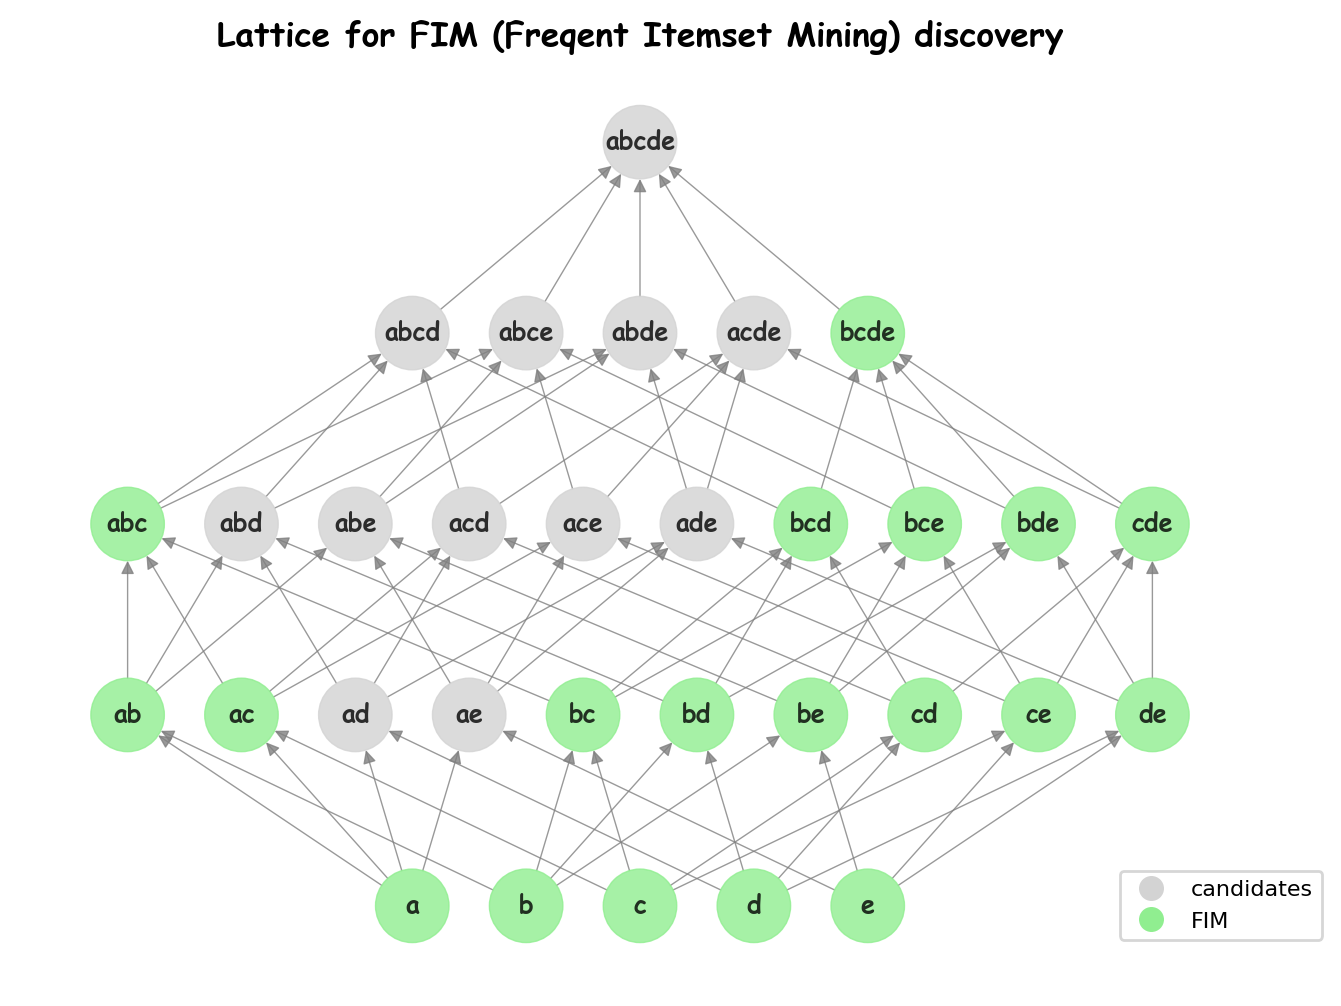

In [15]:
draw_lattice(lattice_data=lattice_data)

- if item is not frequent, then there is no point to generate candidates from it, because it will be also not frequent
- if item is frequent, then it is possible that a generated candidate will be frequent (need to check using `prune` function)
